<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/classify_Gaussian_blurs_occlusion_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task:

With AE, we want to get the output to match the input as closely as possible.

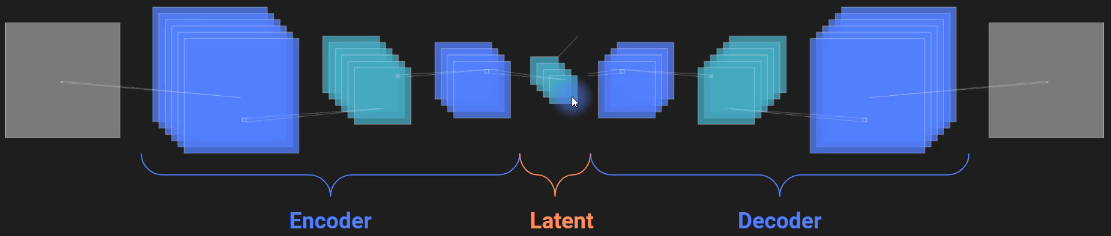

# Convolution vs. Transpose convolution:

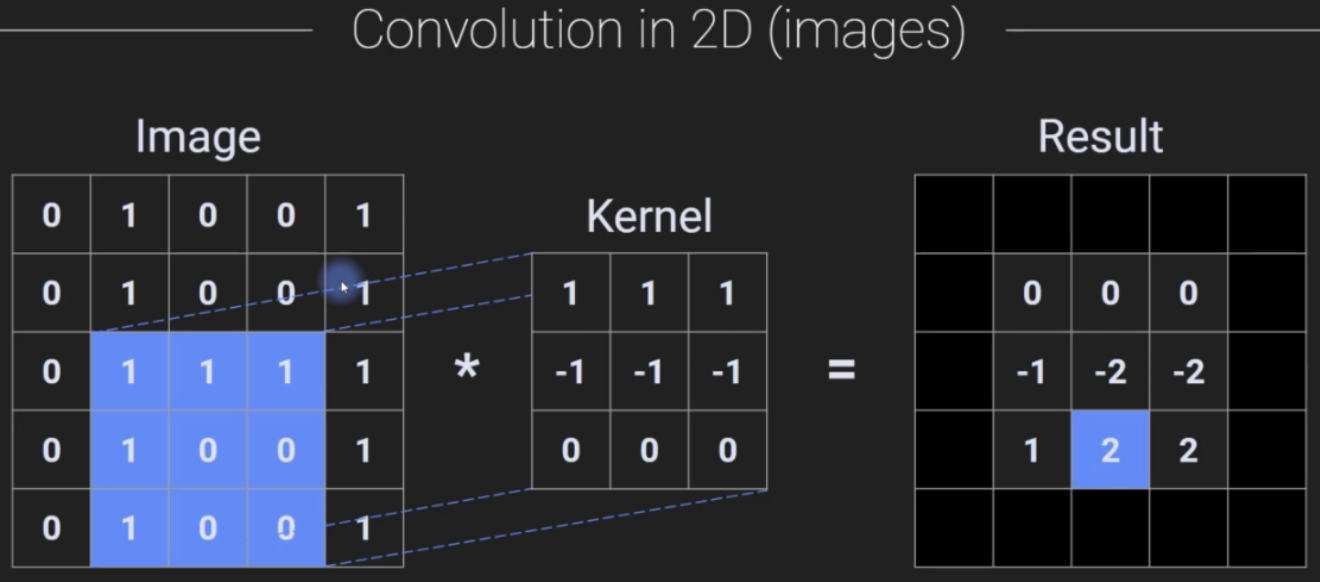

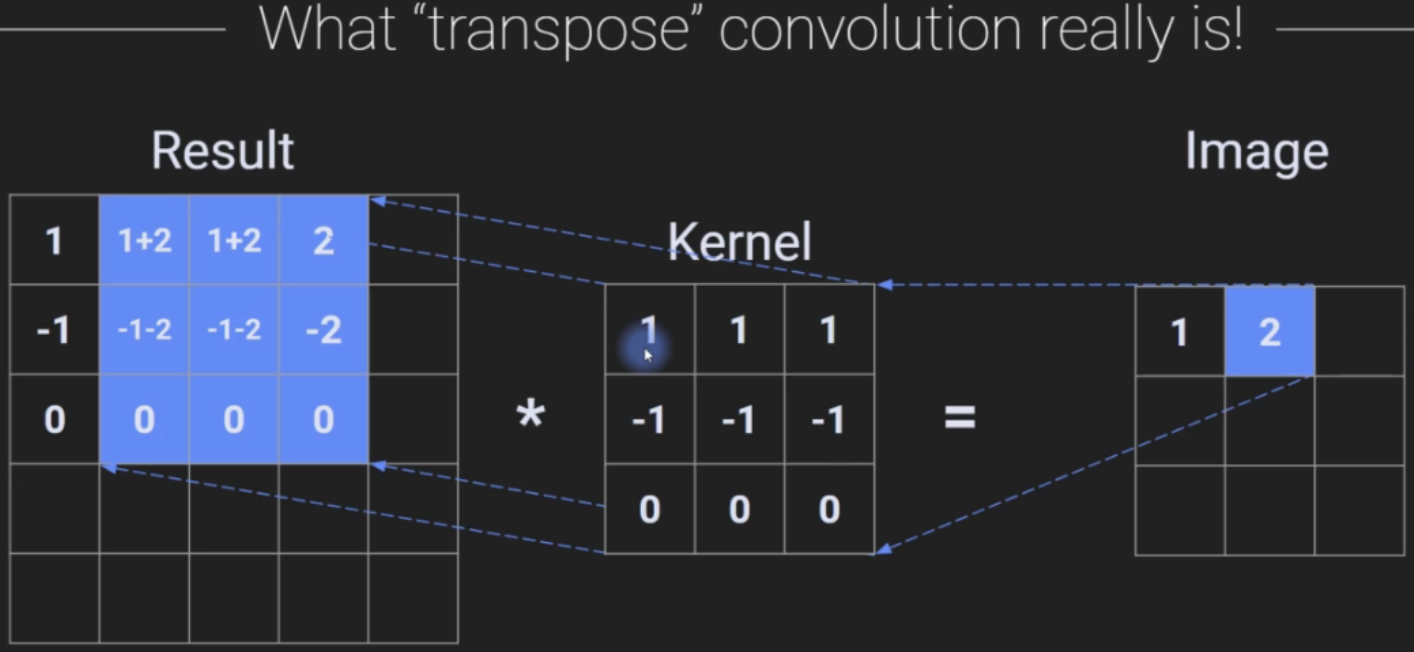



In [31]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary # provide summary info about the total count of parameters in the model

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [32]:
# scratch:
# generate an array of 2 random values from a normal distribution with a mean of 0 and a standard deviation of 1.5:
tmp = 1.5*np.random.randn(2)
print(tmp)

tmp2 = np.arange(10, 20) # half-open interval [start, stop)
print(tmp2)

tmp3 = np.random.choice(tmp2) # generate a random sample from a given 1D array
print(tmp3)

[ 1.62193275 -1.76835449]
[10 11 12 13 14 15 16 17 18 19]
10


In [33]:
# create Gaussian blurs with varying widths and occluding bars:

nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.], 91 elements in total
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss) # [2., ..., 20.], 1000 elements in total

# initialize images tensor
images = torch.zeros(nGauss,1,imgSize,imgSize)

# loop over images:
for i in range(nGauss):

  # random centers, sampled from a normal distribution (mean=0, sd=1.5)
  ro = 1.5*np.random.randn(2) # ro: random offset

  # Gaussian with random centers
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # add noise: random numbers sampled from a standard normal distribution (mean=0, sd=1)
  G  = G + np.random.randn(imgSize,imgSize)/5
  # print("👀", G.shape) # (91, 91)

  # generate occlusion:
  i1 = np.random.choice(np.arange(2,28)) # start idx from [2,28)
  i2 = np.random.choice(np.arange(2,6))  # end idx from [2, 6)
  if np.random.randn()>0: # generate a single random value from a standard normal distribution (mean=0, sd=1)
    G[i1:i1+i2,] = 1 # horizontal bar
  else:
    G[:,i1:i1+i2] = 1 # vertical bar

  # add occlusion:
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [34]:
images.shape

torch.Size([1000, 1, 91, 91])

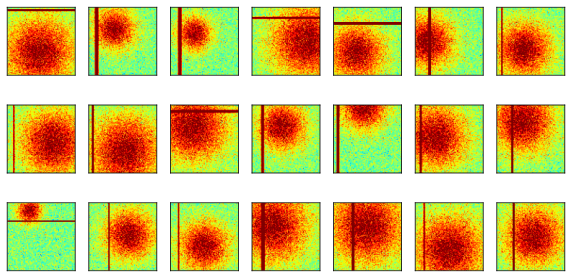

In [35]:
# visualize some images:

fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [36]:
# function to build the model and create a model instance:
def makeTheNet():

  # create a class for the model
  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1), # (inChans, outChans, k, s=1, p=0)
          nn.ReLU(),
          nn.MaxPool2d(2,2), # max pooling
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2), # (inChans, outChans, k, s=1, p=0)
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2), # (inChans, outChans, k, s=1, p=0)
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.MSELoss() # for continuous numerical predictions, to compare all of the output (numeric values) to the input

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

torch.Size([10, 1, 91, 91])


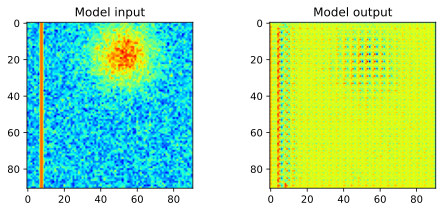

In [37]:
# test the model with one batch:

# build the model & create an model instance
net,lossfun,optimizer = makeTheNet()

# extract the first 10 imgs
yHat = net(images[:10,:,:,:])
print(yHat.shape)

# visualize
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(),cmap='jet') # the 1st image in grayscale
# torch.squeeze: remove any dimensions of size 1 from a PyTorch tensor
# .detach(): remove the tensor from the computational graph (as Matplotlib cannot work with the computational graph, it can only display the image data)
# cmap='jet': set the color map for the image to 'jet', which is a gradient from blue to red
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [38]:
images[0,0,:,:].shape

torch.Size([91, 91])

In [39]:
# display a summary of the architecture for the neural network with an input size of 1 x imgSize x imgSize
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

In [40]:
# a function to train the model:

def function2trainTheModel():

  net,lossfun,optimizer = makeTheNet() # create a new model

  numepochs = 500
  losses = torch.zeros(numepochs) # initialize losses

  for epochi in range(numepochs):

    pics2use = np.random.choice(nGauss,size=32,replace=False)  # select 32 elements without replacement
    X = images[pics2use,:,:,:] # the image set

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

In [41]:
# train the model:
losses,net = function2trainTheModel()

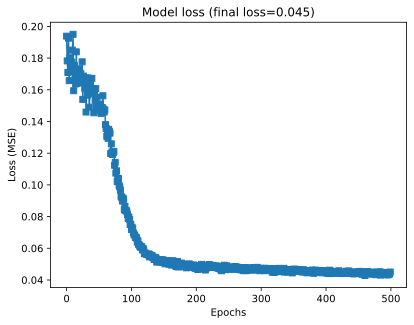

In [42]:
# show the results:

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

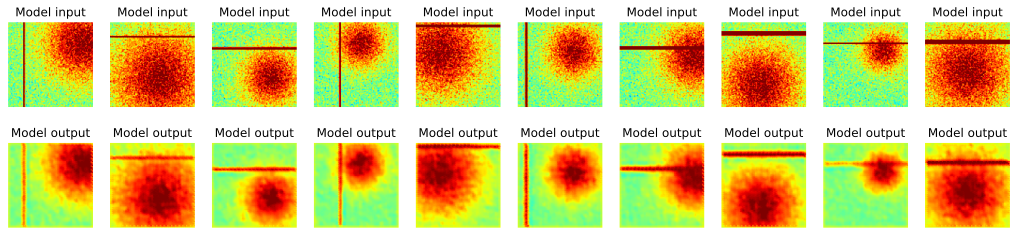

In [45]:
# visualize some images:

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10): # first 10 images

  G = torch.squeeze( X[i,0,:,:] ).detach()    # input image
  O = torch.squeeze( yHat[i,0,:,:] ).detach() # output image

  # fill the 1st row with input images
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  # fill the 2nd row with output images
  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

Observations:

---
- Autoencoder cleans up a lot of the random noise. So the output of the model are cleaner and smoother.
- But it preserves all the occluding bars (learned the bar as an important featrue for the image).